In [ ]:
#!pip install qiskit

In [ ]:
#!pip install qiskit-aer qiskit-ibm-runtime

In [ ]:
#!pip install iqm-benchmarks

In [ ]:
#!pip install iqm-client[qiskit]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from numpy import pi, sqrt, exp

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector

import warnings
warnings.filterwarnings("ignore")

In [3]:
from iqm.iqm_client.models import CircuitCompilationOptions
from iqm.iqm_client.models import DDMode, DDStrategy

from iqm import qiskit_iqm
from iqm.qiskit_iqm import IQMProvider
from iqm.benchmarks.readout_mitigation import apply_readout_error_mitigation

In [4]:
server_url = "https://cocos.resonance.meetiqm.com/garnet"
provider = IQMProvider(server_url, token="")

In [5]:
backend = provider.get_backend()

In [6]:
comp_options_xyxyyxyx = CircuitCompilationOptions(dd_mode=DDMode.ENABLED, dd_strategy=DDStrategy(gate_sequences=[(9, 'XYXYYXYX', 'center')]))

### IQM Garnet + Dynamic Decoupling

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.05
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Step 1/5  t=0.0000  max|u|=1.000000
Step 2/5  t=0.0100  max|u|=1.000000
Step 3/5  t=0.0200  max|u|=1.000000
Step 4/5  t=0.0300  max|u|=1.000000
Step 5/5  t=0.0400  max|u|=1.000000
Quantum evolution finished.
Executed steps: 5

Summary of executed quantum circuits:
 Step 1: depth=93, gates=139, distinct_outcomes=16
 Step 2: depth=105, gates=155, distinct_outcomes=16
 Step 3: depth=104, gates=156, distinct_outcomes=16
 Step 4: depth=105, gates=159, distinct_outcomes=16
 Step 5: depth=104, gates=155, distinct_outcomes=16


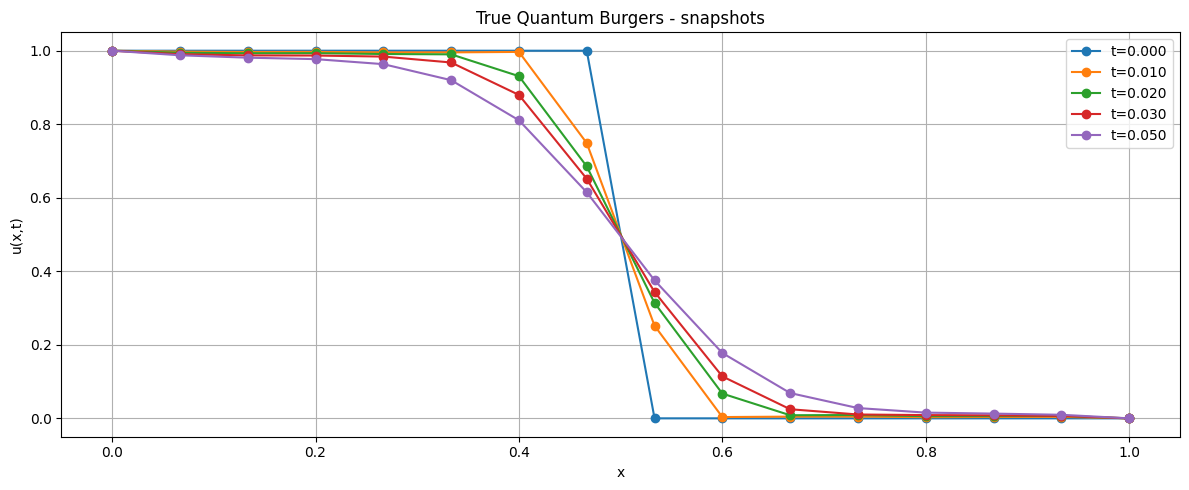

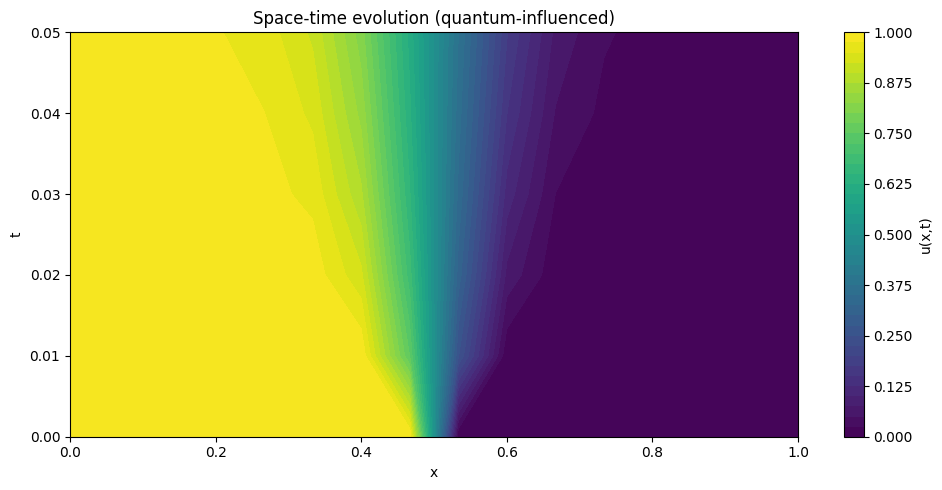

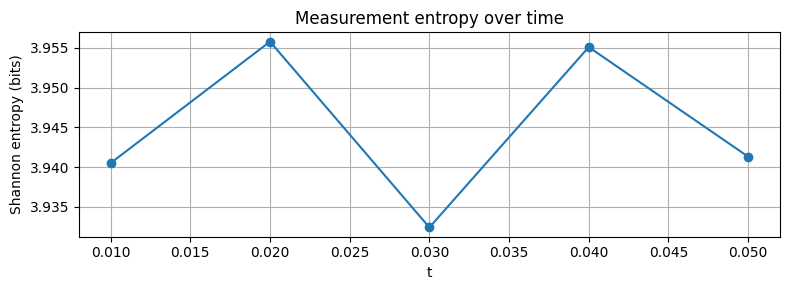

In [8]:
class TrueQuantumBurgersSolver:
    def __init__(self, n_qubits=4, viscosity=0.01, T=0.05, dt=0.01, u_left=1.0, u_right=0.0, shots=4096):
        """
        Initialize solver parameters and grid.
        n_qubits : number of qubits (nx = 2**n_qubits grid points)
        viscosity: diffusion-like coefficient (used to design phases)
        T, dt   : final time and timestep
        u_left, u_right: Dirichlet boundary conditions
        shots   : simulator shots for measurements
        """
        self.n_qubits = int(n_qubits)
        self.nx = 2 ** self.n_qubits
        self.viscosity = float(viscosity)
        self.T = float(T)
        self.dt = float(dt)
        self.u_left = float(u_left)
        self.u_right = float(u_right)
        self.shots = int(shots)

        # spatial domain
        self.L = 1.0
        self.x = np.linspace(0.0, self.L, self.nx)
        self.dx = self.x[1] - self.x[0]

        # backend (AerSimulator)
        self.backend = provider.get_backend()

        print("Initialized TrueQuantumBurgersSolver")
        print(f"  Qubits: {self.n_qubits}, grid points: {self.nx}")
        print(f"  viscosity={self.viscosity}, dt={self.dt}, T={self.T}")
        print(f"  BCs: u(0)={self.u_left} , u(1)={self.u_right}")
        print(f"  Shots per quantum execution: {self.shots}")
        print()

    def initial_condition_riemann(self):
        """Riemann step initial condition."""
        u0 = np.where(self.x <= 0.5, 1.0, 0.0)
        u0[0] = self.u_left
        u0[-1] = self.u_right
        return u0

    def amplitude_encode(self, u_field):
        """
        Encode a real-valued field into a normalized complex amplitude vector.
        This uses the absolute values as densities and a simple phase proportional
        to the cumulative sum of u_field (Madelung-inspired but simplified).
        """
        # avoid negatives for amplitude magnitudes by shifting
        nonneg = u_field - np.min(u_field)
        if np.allclose(nonneg, 0):
            mags = np.ones_like(nonneg) / len(nonneg)
        else:
            mags = nonneg / np.sum(nonneg)

        # phase: cumulative sum scaled to [-pi, pi]
        cumsum = np.cumsum(u_field) * self.dx
        if np.max(np.abs(cumsum)) < 1e-12:
            phases = np.zeros_like(cumsum)
        else:
            phases = (cumsum / np.max(np.abs(cumsum))) * pi

        amps = np.sqrt(mags) * np.exp(1j * phases)
        # make sure length matches 2**n_qubits
        if len(amps) < self.nx:
            padded = np.zeros(self.nx, dtype=complex)
            padded[: len(amps)] = amps
            amps = padded
        elif len(amps) > self.nx:
            amps = amps[: self.nx]

        # normalize
        norm = np.linalg.norm(amps)
        if norm < 1e-12:
            amps = np.zeros(self.nx, dtype=complex)
            amps[0] = 1.0
        else:
            amps /= norm

        return Statevector(amps)

    def build_evolution_circuit(self, u_field):
        """
        Build a hardware-friendly circuit representing one evolution step.
        Approach:
          - Start from amplitude-encoded state (assumed prepared externally)
          - Apply QFT -> kinetic-phase rotations -> QFT^-1
          - Apply simple position-space potential-phase rotations encoding u_field
          - Measure all qubits
        """
        qreg = QuantumRegister(self.n_qubits, "q")
        creg = ClassicalRegister(self.n_qubits, "c")
        qc = QuantumCircuit(qreg, creg, name="evolution_step")

        # QFT -> implement spectral (k-space) phases (diffusion-like)
        qc.append(QFT(self.n_qubits), qreg)
        qc.barrier()

        # Apply simple k-dependent RZ phases to mimic diffusion/kinetic term
        # Use mapping k = 2*pi*m/L (m from 0..nx-1 but wrap negative frequencies)
        for m in range(self.nx):
            # map m to frequency index for n_qubits bitwise; we only have n_qubits wires,
            # so use per-wire phases that are an inexpensive proxy.
            wire = m % self.n_qubits
            k = 2.0 * pi * m / self.L
            phase = -self.viscosity * (k ** 2) * self.dt
            qc.rz(phase, qreg[wire])

        qc.barrier()
        # inverse QFT
        qc.append(QFT(self.n_qubits).inverse(), qreg)
        qc.barrier()

        # position-space nonlinear "potential" rotations using local u_field
        # Map spatial points to qubit wires in a simple repeated manner
        for idx in range(self.nx):
            wire = idx % self.n_qubits
            angle = -u_field[idx] * self.dt
            qc.rz(angle, qreg[wire])
            # add small controlled-phase coupling between adjacent wires for nonlinearity
            if wire > 0:
                qc.crz(0.1 * angle, qreg[wire - 1], qreg[wire])

        qc.barrier()
        qc.measure(qreg, creg)
        return qc

    def run_quantum_execution(self, initial_statevec, circuit):
        """
        Execute a circuit on the backend *starting from an initial statevector*.
        """
        qc = QuantumCircuit(circuit.num_qubits, circuit.num_qubits)
        qc.initialize(np.array(initial_statevec))
        qc = qc.compose(circuit)
        qcirc = transpile(qc, backend=self.backend, optimization_level=3)
        job = self.backend.run(qcirc, shots=self.shots, circuit_compilation_options = comp_options_xyxyyxyx)
        # get the counts and transform the counts into a statevector
        counts = job.result().get_counts()
        psi_noisy = np.array([counts.get(bin(i).replace('0b', '').zfill(self.n_qubits), 0) for i in range(2**self.n_qubits)])
        psi_noisy = np.sqrt(psi_noisy/self.shots)
        psi_noisy = psi_noisy / np.linalg.norm(psi_noisy) if np.linalg.norm(psi_noisy) > 0 else psi_noisy
        # convert evolved state to probabilities and then sample using multinomial to mimic shots
        probs = np.abs(psi_noisy.data) ** 2
        probs = probs / np.sum(probs)

        # sample measurement outcomes according to probs
        outcomes = np.random.multinomial(self.shots, probs)
        counts = {}
        for idx, cnt in enumerate(outcomes):
            if cnt == 0:
                continue
            bitstr = format(idx, "b").zfill(self.n_qubits)
            counts[bitstr] = int(cnt)

        # Also return a transpiled circuit for inspection (transpile the circuit for backend)
        transpiled = transpile(circuit, self.backend, optimization_level=3)
        return counts, transpiled

    def measurements_to_field(self, counts, u_prev):
        """
        Convert measurement counts (bitstring->count) into a velocity-like field.
        We map |psi|^2 -> density; then approximate a velocity update via finite differences
        on the density distribution, blended with the previous field for stability.
        """
        probs = np.zeros(self.nx)
        total = sum(counts.values()) if counts else 1
        for bitstr, c in counts.items():
            idx = int(bitstr, 2)
            if idx < self.nx:
                probs[idx] = c / total

        # small smoothing & ensure positivity
        probs = probs + 1e-12
        probs /= np.sum(probs)

        # Convert probability profile into a tentative velocity via simple scaling:
        # higher local density -> slightly higher velocity (toy model).
        vel_from_probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs) + 1e-12)
        vel_from_probs = vel_from_probs * (np.max(u_prev) - np.min(u_prev) + 1e-12) + np.min(u_prev)

        # blend with previous for stability
        blend_alpha = min(0.5, self.dt)  # small blending factor
        u_new = (1 - blend_alpha) * u_prev + blend_alpha * vel_from_probs

        # impose boundary conditions strongly
        u_new[0] = self.u_left
        u_new[-1] = self.u_right

        # small smoothing filter
        u_new[1:-1] = 0.5 * u_new[1:-1] + 0.25 * (u_new[0:-2] + u_new[2:])

        # clip to reasonable range
        u_new = np.clip(u_new, -5.0, 5.0)
        return u_new

    def quantum_time_step(self, u_current):
        """Run one quantum time step: encode -> build circuit -> execute -> decode."""
        # encode
        sv = self.amplitude_encode(u_current)

        # build circuit (measurements included)
        qc = self.build_evolution_circuit(u_current)

        # execute on simulator starting from the amplitude-encoded state
        counts, transpiled = self.run_quantum_execution(sv, qc)

        # decode
        u_next = self.measurements_to_field(counts, u_current)

        # classical stabilization (very simple implicit diffusion-ish step)
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        if alpha > 0.2:
            u_next[1:-1] = (u_next[1:-1] + alpha * (u_next[:-2] + u_next[2:])) / (1 + 2 * alpha)

        return u_next, transpiled, counts

    def solve(self, max_steps=None, verbose=True):
        """Evolve for T seconds (or limited by max_steps). Returns t_points, history, circuits, counts."""
        u = self.initial_condition_riemann()
        t_points = [0.0]
        u_hist = [u.copy()]
        circuit_list = []
        counts_list = []

        n_steps = int(np.ceil(self.T / self.dt))
        if max_steps is not None:
            n_steps = min(n_steps, max_steps)

        t = 0.0
        for step in range(n_steps):
            if verbose:
                print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")
            u, transpiled, counts = self.quantum_time_step(u)
            t += self.dt
            t_points.append(t)
            u_hist.append(u.copy())
            circuit_list.append(transpiled)
            counts_list.append(counts)

            # simple stability break
            if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
                print("Stability problem encountered; stopping early.")
                break

        if verbose:
            print("Quantum evolution finished.")
            print(f"Executed steps: {len(circuit_list)}")

        return np.array(t_points), np.array(u_hist), circuit_list, counts_list

    def plot_solution(self, t_points, u_hist, counts_list=None):
        """Two-panel plot: snapshots and space-time contour. Optionally show entropy plot."""
        plt.figure(figsize=(12, 5))
        # snapshots
        n_snap = min(5, len(t_points))
        indices = np.linspace(0, len(t_points) - 1, n_snap, dtype=int)
        for idx in indices:
            plt.plot(self.x, u_hist[idx], label=f"t={t_points[idx]:.3f}", marker="o")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title("True Quantum Burgers - snapshots")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # space-time contour
        plt.figure(figsize=(10, 5))
        X, T = np.meshgrid(self.x, t_points)
        plt.contourf(X, T, u_hist, levels=40, cmap="viridis")
        plt.colorbar(label="u(x,t)")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Space-time evolution (quantum-influenced)")
        plt.tight_layout()
        plt.show()

        # entropy from counts (if provided)
        if counts_list:
            entropies = []
            for counts in counts_list:
                total = sum(counts.values()) if counts else 1
                probs = np.array([c / total for c in counts.values()]) if counts else np.array([1.0])
                ent = -np.sum(probs * np.log2(probs + 1e-12))
                entropies.append(ent)
            plt.figure(figsize=(8, 3))
            plt.plot(t_points[1 : 1 + len(entropies)], entropies, "-o")
            plt.xlabel("t")
            plt.ylabel("Shannon entropy (bits)")
            plt.title("Measurement entropy over time")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


if __name__ == "__main__":
    # Instantiate solver (example configuration)
    solver = TrueQuantumBurgersSolver(
        n_qubits=4,      # 16 grid points
        viscosity=0.01,
        T=0.05,
        dt=0.01,
        u_left=1.0,
        u_right=0.0,
        shots=4096,
    )

    # Run for a few steps (limit for demonstration)
    t_pts, u_hist, circuits, counts = solver.solve(max_steps=5, verbose=True)

    # Basic analysis prints
    print("\nSummary of executed quantum circuits:")
    for i, qc in enumerate(circuits):
        print(f" Step {i+1}: depth={qc.depth()}, gates={len(qc.data)}, distinct_outcomes={len(counts[i])}")

    # Plot results
    solver.plot_solution(t_pts, u_hist, counts)

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096



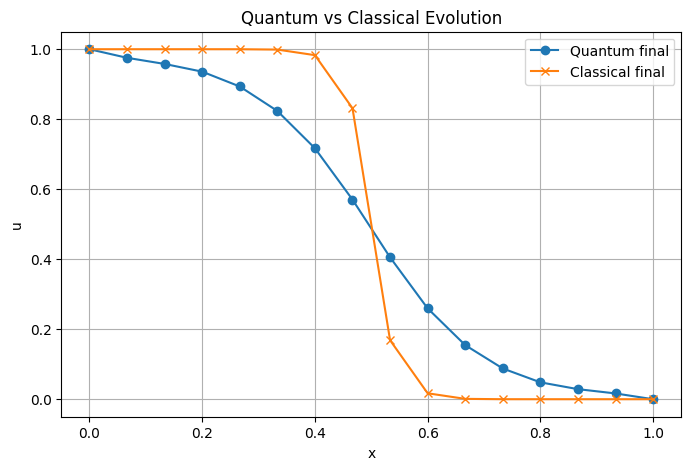

L2 difference between quantum and classical final states: 0.580578


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Instantiate quantum solver
solver_q = TrueQuantumBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0, shots=4096
)

# Instantiate a "classical version" by overriding the quantum step
class ClassicalBurgersSolver(TrueQuantumBurgersSolver):
    def quantum_time_step(self, u_current):
        # Simple classical smoothing + advection
        u_next = u_current.copy()
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        u_next[1:-1] = (u_next[1:-1] +
                        alpha * (u_next[:-2] - 2 * u_next[1:-1] + u_next[2:]))
        return u_next, None, None

solver_c = ClassicalBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0
)

# Run both solvers
t_q, u_q, _, _ = solver_q.solve(max_steps=10, verbose=False)
t_c, u_c, _, _ = solver_c.solve(max_steps=10, verbose=False)

# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(solver_q.x, u_q[-1], label="Quantum final", marker='o')
plt.plot(solver_c.x, u_c[-1], label="Classical final", marker='x')
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("Quantum vs Classical Evolution")
plt.grid(True)
plt.show()

# Print L2 difference
diff = np.linalg.norm(u_q[-1] - u_c[-1])
print(f"L2 difference between quantum and classical final states: {diff:.6f}")

### IQM Garnet + Readout Error Mitigation

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.05
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Step 1/5  t=0.0000  max|u|=1.000000
Step 2/5  t=0.0100  max|u|=1.000000
Step 3/5  t=0.0200  max|u|=1.000000
Step 4/5  t=0.0300  max|u|=1.000000
Step 5/5  t=0.0400  max|u|=1.000000
Quantum evolution finished.
Executed steps: 5

Summary of executed quantum circuits:
 Step 1: depth=93, gates=139, distinct_outcomes=16
 Step 2: depth=105, gates=156, distinct_outcomes=16
 Step 3: depth=104, gates=158, distinct_outcomes=16
 Step 4: depth=105, gates=160, distinct_outcomes=16
 Step 5: depth=104, gates=158, distinct_outcomes=16


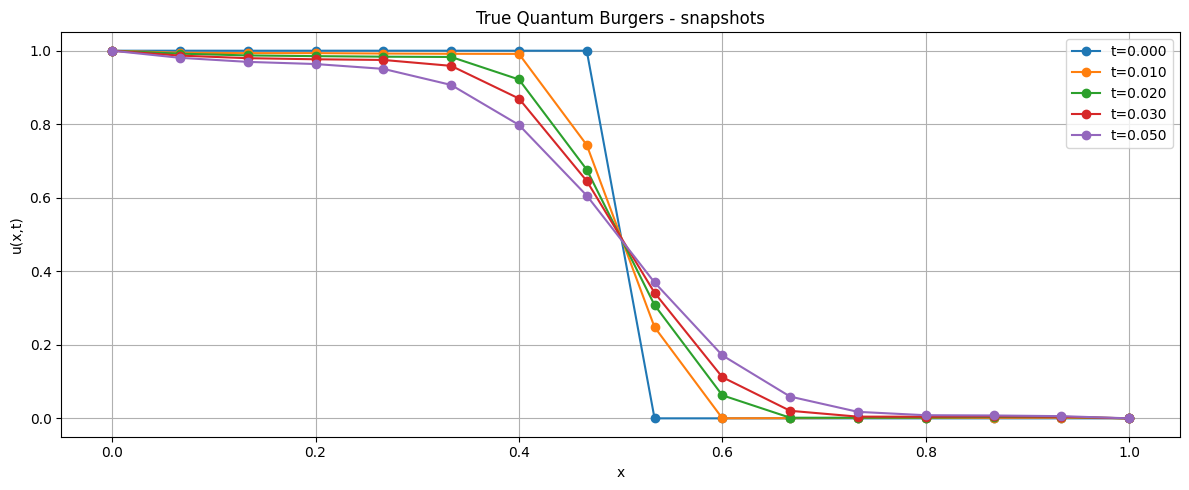

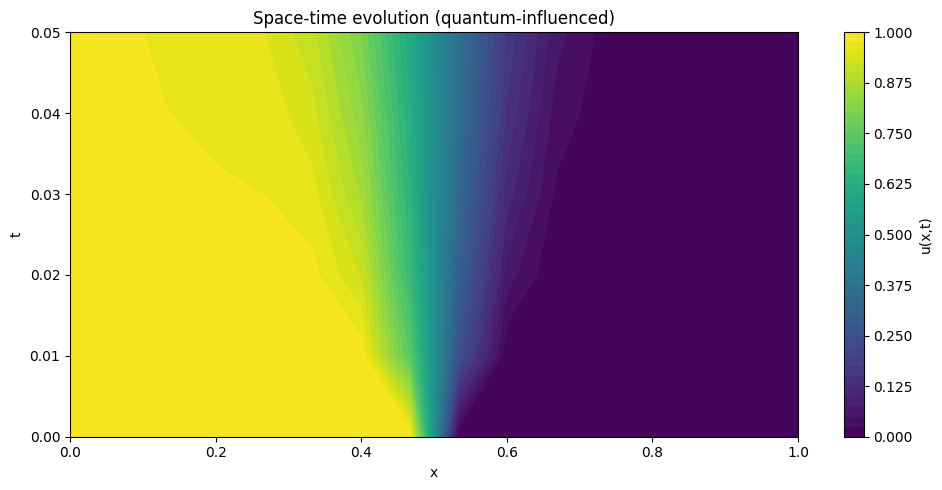

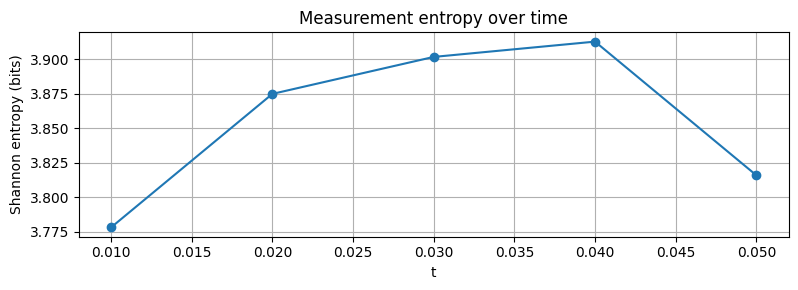

In [11]:
class TrueQuantumBurgersSolver:
    def __init__(self, n_qubits=4, viscosity=0.01, T=0.05, dt=0.01, u_left=1.0, u_right=0.0, shots=4096):
        """
        Initialize solver parameters and grid.
        n_qubits : number of qubits (nx = 2**n_qubits grid points)
        viscosity: diffusion-like coefficient (used to design phases)
        T, dt   : final time and timestep
        u_left, u_right: Dirichlet boundary conditions
        shots   : simulator shots for measurements
        """
        self.n_qubits = int(n_qubits)
        self.nx = 2 ** self.n_qubits
        self.viscosity = float(viscosity)
        self.T = float(T)
        self.dt = float(dt)
        self.u_left = float(u_left)
        self.u_right = float(u_right)
        self.shots = int(shots)

        # spatial domain
        self.L = 1.0
        self.x = np.linspace(0.0, self.L, self.nx)
        self.dx = self.x[1] - self.x[0]

        # backend (AerSimulator)
        self.backend = provider.get_backend()

        print("Initialized TrueQuantumBurgersSolver")
        print(f"  Qubits: {self.n_qubits}, grid points: {self.nx}")
        print(f"  viscosity={self.viscosity}, dt={self.dt}, T={self.T}")
        print(f"  BCs: u(0)={self.u_left} , u(1)={self.u_right}")
        print(f"  Shots per quantum execution: {self.shots}")
        print()

    def initial_condition_riemann(self):
        """Riemann step initial condition."""
        u0 = np.where(self.x <= 0.5, 1.0, 0.0)
        u0[0] = self.u_left
        u0[-1] = self.u_right
        return u0

    def amplitude_encode(self, u_field):
        """
        Encode a real-valued field into a normalized complex amplitude vector.
        This uses the absolute values as densities and a simple phase proportional
        to the cumulative sum of u_field (Madelung-inspired but simplified).
        """
        # avoid negatives for amplitude magnitudes by shifting
        nonneg = u_field - np.min(u_field)
        if np.allclose(nonneg, 0):
            mags = np.ones_like(nonneg) / len(nonneg)
        else:
            mags = nonneg / np.sum(nonneg)

        # phase: cumulative sum scaled to [-pi, pi]
        cumsum = np.cumsum(u_field) * self.dx
        if np.max(np.abs(cumsum)) < 1e-12:
            phases = np.zeros_like(cumsum)
        else:
            phases = (cumsum / np.max(np.abs(cumsum))) * pi

        amps = np.sqrt(mags) * np.exp(1j * phases)
        # make sure length matches 2**n_qubits
        if len(amps) < self.nx:
            padded = np.zeros(self.nx, dtype=complex)
            padded[: len(amps)] = amps
            amps = padded
        elif len(amps) > self.nx:
            amps = amps[: self.nx]

        # normalize
        norm = np.linalg.norm(amps)
        if norm < 1e-12:
            amps = np.zeros(self.nx, dtype=complex)
            amps[0] = 1.0
        else:
            amps /= norm

        return Statevector(amps)

    def build_evolution_circuit(self, u_field):
        """
        Build a hardware-friendly circuit representing one evolution step.
        Approach:
          - Start from amplitude-encoded state (assumed prepared externally)
          - Apply QFT -> kinetic-phase rotations -> QFT^-1
          - Apply simple position-space potential-phase rotations encoding u_field
          - Measure all qubits
        """
        qreg = QuantumRegister(self.n_qubits, "q")
        creg = ClassicalRegister(self.n_qubits, "c")
        qc = QuantumCircuit(qreg, creg, name="evolution_step")

        # QFT -> implement spectral (k-space) phases (diffusion-like)
        qc.append(QFT(self.n_qubits), qreg)
        qc.barrier()

        # Apply simple k-dependent RZ phases to mimic diffusion/kinetic term
        # Use mapping k = 2*pi*m/L (m from 0..nx-1 but wrap negative frequencies)
        for m in range(self.nx):
            # map m to frequency index for n_qubits bitwise; we only have n_qubits wires,
            # so use per-wire phases that are an inexpensive proxy.
            wire = m % self.n_qubits
            k = 2.0 * pi * m / self.L
            phase = -self.viscosity * (k ** 2) * self.dt
            qc.rz(phase, qreg[wire])

        qc.barrier()
        # inverse QFT
        qc.append(QFT(self.n_qubits).inverse(), qreg)
        qc.barrier()

        # position-space nonlinear "potential" rotations using local u_field
        # Map spatial points to qubit wires in a simple repeated manner
        for idx in range(self.nx):
            wire = idx % self.n_qubits
            angle = -u_field[idx] * self.dt
            qc.rz(angle, qreg[wire])
            # add small controlled-phase coupling between adjacent wires for nonlinearity
            if wire > 0:
                qc.crz(0.1 * angle, qreg[wire - 1], qreg[wire])

        qc.barrier()
        qc.measure(qreg, creg)
        return qc

    def run_quantum_execution(self, initial_statevec, circuit):
        """
        Execute a circuit on the backend *starting from an initial statevector*.
        """
        qc = QuantumCircuit(circuit.num_qubits, circuit.num_qubits)
        qc.initialize(np.array(initial_statevec))
        qc = qc.compose(circuit)
        qcirc = transpile(qc, backend=self.backend, optimization_level=3)
        job = self.backend.run(qcirc, shots=self.shots)
        # Readout error mitigation
        iqm_circuits = [qcirc]
        raw_counts = [job.result().get_counts()]

        readout_mitigated_results1 = apply_readout_error_mitigation(
            backend_arg=self.backend,
            transpiled_circuits=iqm_circuits,
            counts=raw_counts,
            mit_shots=self.shots
        )

        prob_dict = readout_mitigated_results1[0][0]
        # get the counts and transform the counts into a statevector
        counts = {k: int(v * self.shots) for k, v in prob_dict.items()}
        psi_noisy = np.array([counts.get(bin(i).replace('0b', '').zfill(self.n_qubits), 0) for i in range(2**self.n_qubits)])
        psi_noisy = np.sqrt(psi_noisy/self.shots)
        psi_noisy = psi_noisy / np.linalg.norm(psi_noisy) if np.linalg.norm(psi_noisy) > 0 else psi_noisy
        # convert evolved state to probabilities and then sample using multinomial to mimic shots
        probs = np.abs(psi_noisy.data) ** 2
        probs = probs / np.sum(probs)

        # sample measurement outcomes according to probs
        outcomes = np.random.multinomial(self.shots, probs)
        counts = {}
        for idx, cnt in enumerate(outcomes):
            if cnt == 0:
                continue
            bitstr = format(idx, "b").zfill(self.n_qubits)
            counts[bitstr] = int(cnt)

        # Also return a transpiled circuit for inspection (transpile the circuit for backend)
        transpiled = transpile(circuit, self.backend, optimization_level=3)
        return counts, transpiled

    def measurements_to_field(self, counts, u_prev):
        """
        Convert measurement counts (bitstring->count) into a velocity-like field.
        We map |psi|^2 -> density; then approximate a velocity update via finite differences
        on the density distribution, blended with the previous field for stability.
        """
        probs = np.zeros(self.nx)
        total = sum(counts.values()) if counts else 1
        for bitstr, c in counts.items():
            idx = int(bitstr, 2)
            if idx < self.nx:
                probs[idx] = c / total

        # small smoothing & ensure positivity
        probs = probs + 1e-12
        probs /= np.sum(probs)

        # Convert probability profile into a tentative velocity via simple scaling:
        # higher local density -> slightly higher velocity (toy model).
        vel_from_probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs) + 1e-12)
        vel_from_probs = vel_from_probs * (np.max(u_prev) - np.min(u_prev) + 1e-12) + np.min(u_prev)

        # blend with previous for stability
        blend_alpha = min(0.5, self.dt)  # small blending factor
        u_new = (1 - blend_alpha) * u_prev + blend_alpha * vel_from_probs

        # impose boundary conditions strongly
        u_new[0] = self.u_left
        u_new[-1] = self.u_right

        # small smoothing filter
        u_new[1:-1] = 0.5 * u_new[1:-1] + 0.25 * (u_new[0:-2] + u_new[2:])

        # clip to reasonable range
        u_new = np.clip(u_new, -5.0, 5.0)
        return u_new

    def quantum_time_step(self, u_current):
        """Run one quantum time step: encode -> build circuit -> execute -> decode."""
        # encode
        sv = self.amplitude_encode(u_current)

        # build circuit (measurements included)
        qc = self.build_evolution_circuit(u_current)

        # execute on simulator starting from the amplitude-encoded state
        counts, transpiled = self.run_quantum_execution(sv, qc)

        # decode
        u_next = self.measurements_to_field(counts, u_current)

        # classical stabilization (very simple implicit diffusion-ish step)
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        if alpha > 0.2:
            u_next[1:-1] = (u_next[1:-1] + alpha * (u_next[:-2] + u_next[2:])) / (1 + 2 * alpha)

        return u_next, transpiled, counts

    def solve(self, max_steps=None, verbose=True):
        """Evolve for T seconds (or limited by max_steps). Returns t_points, history, circuits, counts."""
        u = self.initial_condition_riemann()
        t_points = [0.0]
        u_hist = [u.copy()]
        circuit_list = []
        counts_list = []

        n_steps = int(np.ceil(self.T / self.dt))
        if max_steps is not None:
            n_steps = min(n_steps, max_steps)

        t = 0.0
        for step in range(n_steps):
            if verbose:
                print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")
            u, transpiled, counts = self.quantum_time_step(u)
            t += self.dt
            t_points.append(t)
            u_hist.append(u.copy())
            circuit_list.append(transpiled)
            counts_list.append(counts)

            # simple stability break
            if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
                print("Stability problem encountered; stopping early.")
                break

        if verbose:
            print("Quantum evolution finished.")
            print(f"Executed steps: {len(circuit_list)}")

        return np.array(t_points), np.array(u_hist), circuit_list, counts_list

    def plot_solution(self, t_points, u_hist, counts_list=None):
        """Two-panel plot: snapshots and space-time contour. Optionally show entropy plot."""
        plt.figure(figsize=(12, 5))
        # snapshots
        n_snap = min(5, len(t_points))
        indices = np.linspace(0, len(t_points) - 1, n_snap, dtype=int)
        for idx in indices:
            plt.plot(self.x, u_hist[idx], label=f"t={t_points[idx]:.3f}", marker="o")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title("True Quantum Burgers - snapshots")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # space-time contour
        plt.figure(figsize=(10, 5))
        X, T = np.meshgrid(self.x, t_points)
        plt.contourf(X, T, u_hist, levels=40, cmap="viridis")
        plt.colorbar(label="u(x,t)")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Space-time evolution (quantum-influenced)")
        plt.tight_layout()
        plt.show()

        # entropy from counts (if provided)
        if counts_list:
            entropies = []
            for counts in counts_list:
                total = sum(counts.values()) if counts else 1
                probs = np.array([c / total for c in counts.values()]) if counts else np.array([1.0])
                ent = -np.sum(probs * np.log2(probs + 1e-12))
                entropies.append(ent)
            plt.figure(figsize=(8, 3))
            plt.plot(t_points[1 : 1 + len(entropies)], entropies, "-o")
            plt.xlabel("t")
            plt.ylabel("Shannon entropy (bits)")
            plt.title("Measurement entropy over time")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


if __name__ == "__main__":
    # Instantiate solver (example configuration)
    solver = TrueQuantumBurgersSolver(
        n_qubits=4,      # 16 grid points
        viscosity=0.01,
        T=0.05,
        dt=0.01,
        u_left=1.0,
        u_right=0.0,
        shots=4096,
    )

    # Run for a few steps (limit for demonstration)
    t_pts, u_hist, circuits, counts = solver.solve(max_steps=5, verbose=True)

    # Basic analysis prints
    print("\nSummary of executed quantum circuits:")
    for i, qc in enumerate(circuits):
        print(f" Step {i+1}: depth={qc.depth()}, gates={len(qc.data)}, distinct_outcomes={len(counts[i])}")

    # Plot results
    solver.plot_solution(t_pts, u_hist, counts)

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096



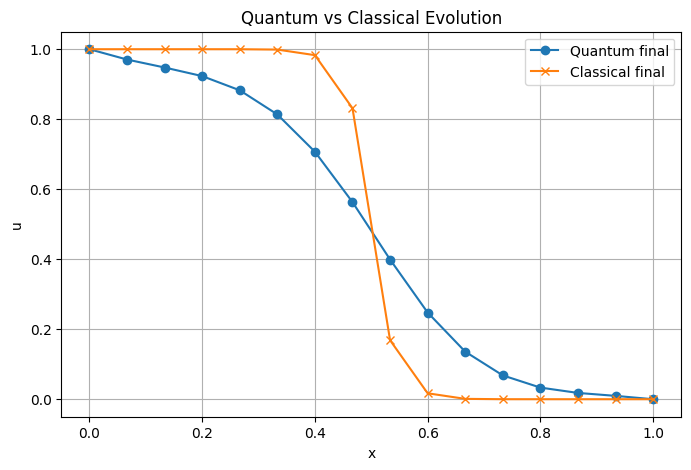

L2 difference between quantum and classical final states: 0.580034


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Instantiate quantum solver
solver_q = TrueQuantumBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0, shots=4096
)

# Instantiate a "classical version" by overriding the quantum step
class ClassicalBurgersSolver(TrueQuantumBurgersSolver):
    def quantum_time_step(self, u_current):
        # Simple classical smoothing + advection
        u_next = u_current.copy()
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        u_next[1:-1] = (u_next[1:-1] +
                        alpha * (u_next[:-2] - 2 * u_next[1:-1] + u_next[2:]))
        return u_next, None, None

solver_c = ClassicalBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0
)

# Run both solvers
t_q, u_q, _, _ = solver_q.solve(max_steps=10, verbose=False)
t_c, u_c, _, _ = solver_c.solve(max_steps=10, verbose=False)

# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(solver_q.x, u_q[-1], label="Quantum final", marker='o')
plt.plot(solver_c.x, u_c[-1], label="Classical final", marker='x')
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("Quantum vs Classical Evolution")
plt.grid(True)
plt.show()

# Print L2 difference
diff = np.linalg.norm(u_q[-1] - u_c[-1])
print(f"L2 difference between quantum and classical final states: {diff:.6f}")